# 0. data prepare

In [9]:
import os
import shutil


def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

market_dir = '/home/hui/dataset/market1501/'
save_dir = market_dir + "/features"
force_regenerate = False
if force_regenerate or (not os.path.exists(market_dir + 'classify/')):
    classfy_dir = os.path.join(market_dir, 'classify/')
    mkdir_if_not_exist([classfy_dir])
    images_dir = market_dir + 'bounding_box_train'
    for i, image_name in enumerate(os.listdir(images_dir)):
        if image_name.split('.')[-1] != 'jpg': continue
        person_id = image_name.split('_')[0]
        mkdir_if_not_exist([classfy_dir, person_id])
        shutil.copy(os.path.join(images_dir, image_name), os.path.join(classfy_dir, person_id))
        if i % 1000==0: print i, image_name, person_id

# 1. import needed package

In [10]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
from cifar10_utils import show_images
%matplotlib inline
import mxnet.gluon.model_zoo.vision as models
from tqdm import tqdm

ctx = mx.gpu(0)
num_classes = 751
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/root/Util/miniconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor. 

# 2. data loader, data argument

In [11]:
"""
data loader
"""
batch_size = 16
# imagenet mean and std, set None or not set will use as default for image.CreateAugmenter function
mean = np.array([123.68, 116.28, 103.53])
std = np.array([58.395, 57.12, 57.375])

def _transform_test(data, label):
    im = data.astype('float32')
    im = image.imresize(im, 224, 224, interp=1) / 255
    auglist = image.CreateAugmenter(data_shape=(3, 224, 224), rand_crop=False, mean=mean, std=std)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def inv_normalize(data, clip=True):
    images = data.transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.ImageFolderDataset(root=market_dir + '/classify/', flag=1, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    #test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    #test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, None

In [12]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.astype('float32')
    im = image.imresize(im, 224, 224, interp=1) / 255
    auglist = image.CreateAugmenter(data_shape=(3, 224, 224), rand_crop=False, rand_mirror=True, mean=mean, std=std)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')

"""
def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
"""
print 

In [5]:
train_data, _ = data_loader(batch_size, _transform_test)

(16L, 3L, 224L, 224L) (16L, 1L)


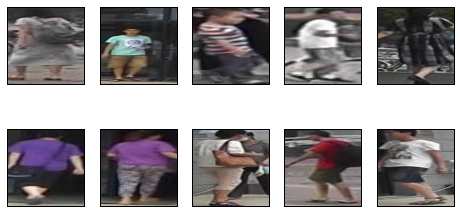


[[ 332.  580.  367.  106.  553.  115.  478.  633.  306.  583.]]
<NDArray 1x10 @cpu(0)>


In [7]:
for data, label in train_data:
    print data.shape, label.shape
    show_images(inv_normalize(data[:10, :, :, :]))
    print label[:10].T
    break


# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [5]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1.reshape((-1,)), num_class)
    y2 = nd.one_hot(y2.reshape((-1,)), num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, num_classes)
    break

NameError: name 'mixup' is not defined

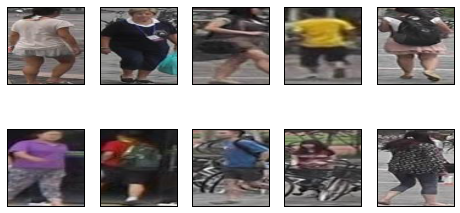


[[ 0.         0.0543404  0.        ...,  0.         0.         0.       ]
 [ 0.         0.         0.        ...,  0.         0.         0.       ]
 [ 0.         0.         0.        ...,  0.         0.         0.       ]
 ..., 
 [ 0.         0.         0.        ...,  0.         0.         0.       ]
 [ 0.         0.         0.        ...,  0.         0.         0.       ]
 [ 0.         0.         0.        ...,  0.         0.         0.       ]]
<NDArray 10x751 @cpu(0)>


In [17]:
show_images(inv_normalize(data[:10]))
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

#print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [6]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [7]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    

    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, combine_batch=False):
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 50 == 0:
            show_data(data[:10], clip)
            print data[0, 0, :2, :10]
            print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    return data, (nd.mean(loss).asscalar(),)

def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)

In [ ]:
ny = get_soft_label(y, 10, 0.1)
print nd.sum(ny, axis=1)

## 3.2 view result

In [10]:
net = ResNet(10)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
for data, label in train_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

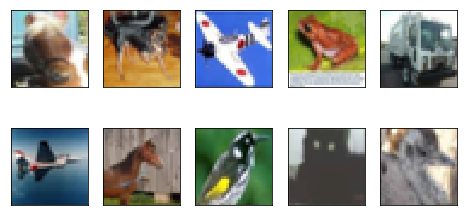

iter: 5 loss: -0.653574
iter: 10 loss: -8.564
iter: 15 loss: -20.576
iter: 20 loss: -24.9794
iter: 25 loss: -27.0003
iter: 30 loss: -28.422
iter: 35 loss: -29.5991
iter: 40 loss: -30.2958
iter: 45 loss: -30.7695


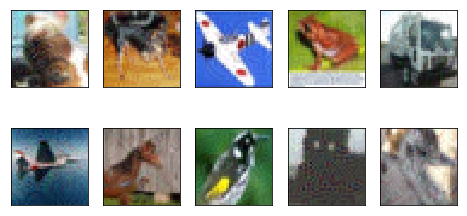


[[ 0.84831941  0.43412015  0.055559    0.40172759  0.22163963  0.3280842
   0.43882918  0.57305658  0.55760622  0.71607369]
 [ 0.6209408   0.33316466  0.2598415   0.10612462  0.08188817  0.53343666
   0.47439697  0.40720972  0.66907173  1.33878851]]
<NDArray 2x10 @gpu(0)>

[[ 0.00107157 -0.00995333  0.02543991 -0.00150443  0.00290885 -0.01448712
   0.00147239  0.01359361 -0.03987353  0.01315716]
 [-0.00556491  0.00892302  0.00936656 -0.02188207 -0.01906253  0.00676367
   0.01128476  0.02287036  0.08281443 -0.01383139]]
<NDArray 2x10 @gpu(0)>
iter: 50 loss: -31.2375
iter: 55 loss: -31.5906
iter: 60 loss: -31.8804
iter: 65 loss: -32.137
iter: 70 loss: -32.3555
iter: 75 loss: -32.5918
iter: 80 loss: -32.7849
iter: 85 loss: -32.9588
iter: 90 loss: -33.1117
iter: 95 loss: -33.2321


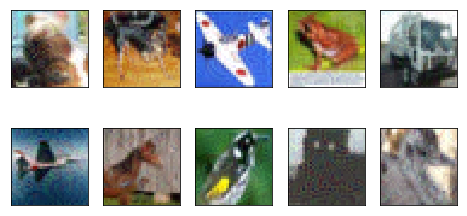


[[ 0.86086494  0.45774978 -0.04080509  0.42361343  0.22738311  0.36224753
   0.41933003  0.54379052  0.54480875  0.7476331 ]
 [ 0.6208269   0.32305709  0.25822848  0.12950258  0.16053845  0.56330878
   0.44187349  0.36415511  0.60530257  1.31449234]]
<NDArray 2x10 @gpu(0)>

[[-0.00081484  0.00033939  0.01105584 -0.01771183  0.04914688 -0.0776163
   0.0074151  -0.00136637 -0.04334011 -0.01749903]
 [ 0.02110897  0.00915922  0.01287662  0.00286914 -0.04126899 -0.0169199
   0.02211018  0.05105556  0.09108437  0.07623332]]
<NDArray 2x10 @gpu(0)>
iter: 100 loss: -33.3837
-33.3837


In [10]:
show_data(data[:10], False)
backgrad_data, (loss,) = generate_backgrad_data(net, data.copy(), label, max_iters=100, lr=0.1, iter_log=True, clip=False)
print loss

## 3.3 other implement

In [10]:
if False:
    data_dict = gluon.ParameterDict()
    data_param = gluon.Parameter('data')
    data_param.set_data(data)
    data_dict.update({'data': data_param})
    data_dict['data'].set_data(data)
    trainer = gluon.Trainer(data_dict, 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    with autograd.record():
        output = net(data.as_in_context(ctx))
        loss = -loss_f(output, label.as_in_context(ctx))
    print data_dict['data'].data()
    loss.backward()
    #SGD(data, 0.1)
    import mxnet.optimizer as opt
    optimizer = opt.create('sgd', **{'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})#, param_dict=param_dict)
    updater = opt.get_updater(optimizer)

# 4. define train function

In [8]:
"""
train
"""
import datetime
import utils
import sys
from random import random

num_class = 10

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2, back_grad_args=None):
    
    def train_batch(data, label, i, use_backgrad, loss_f):
        data = data.as_in_context(ctx)
        _label = label.copy()
        label = label.as_in_context(ctx)
        
        # generate backgrad data
        _bloss = None
        if use_backgrad:
            args = back_grad_args
            args['prob'] = args.get('prob', 1)      # prob to use back grad data argument to prove origin data is used.
            if random() <= args['prob']:
                args['max_iters'], args['lr'] = args.get('max_iters', 60), args.get('lr', 0.1)
                _data, (_bloss,) = generate_backgrad_data(args['net'], data, label, args['max_iters'], args['lr'], iter_log=False)
                if args.has_key('soft_label_th'):
                    label = get_soft_label(label, num_class, args['soft_label_th'])
                    loss_f = args['soft_label_loss_f']
                    
                if args.has_key('show_iters') and i % args['show_iters'] == 0:
                    show_data(data[:5])
                    
                if args.has_key('attach_batch') and args['attach_batch'] == True:
                    data = nd.concat(data, _data, dim=0)
                    label = nd.concat(label, label, dim=0)
                    _label = nd.concat(_label, _label, dim=0)
                else:
                    data = _data
                    
        label = label.as_in_context(ctx)            
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
#         if not use_mixup and (back_grad_args is None or not args.has_key('soft_label_th')):
#             _acc = utils.accuracy(output, label)
        if not use_mixup:
            _acc = utils.accuracy(output, _label.as_in_context(ctx))
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc, _bloss
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        bloss, btime = 0., 0
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        
        # back grad
        use_backgrad = False
        if back_grad_args is not None:
            args = back_grad_args
            if args.has_key('take_turn'):
                args['take_turn'] = not args['take_turn'] # only odd epoch(start 0) will use back grad

            if (not args.has_key('take_turn')) or args['take_turn'] == True:
                if not args.has_key('prob'): print "# back grad turn." 
                use_backgrad = True
        
        # mixup
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc, _bloss = train_batch(data, label, i, use_backgrad, loss_f)
                train_loss += _loss
                if _acc is not None: train_acc += _acc
                if _bloss is not None: 
                    bloss += _bloss
                    btime += 1
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _, _bloss = train_batch(data, label, i, use_backgrad, loss_f)
                train_loss += _loss
                if _bloss is not None: 
                    bloss += _bloss
                    btime += 1
                i += 1
        
        # log info
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
            
        if back_grad_args is not None:
            epoch_str += (", bloss %.5f" % (-bloss / btime))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP

In [1]:
def get_image_info(image_dir, image_name, transform=None):
    img = image.imread(os.path.join(image_dir, image_name), flag=1)
    image_name_list = image_name.split('_')
    label = int(image_name_list[0])
    cam = int(image_name_list[1].split('s')[0][1:])
    if transform is not None: 
        img, label = transform(img, label)
    return img, label, cam

def test_data_loader(image_dir, batch_size):
    batch_data, batch_label, batch_cam, batch_i = None, nd.zeros(shape=(batch_size,)), nd.zeros(shape=(batch_size,)), 0
    for image_name in os.listdir(image_dir):
        if image_name.split('.')[-1] != 'jpg': continue
        if int(image_name.split('_')[0]) == -1: continue
        image_path = os.path.join(image_dir, image_name)
        img, label, cam = get_image_info(image_dir, image_name, transform=_transform_test)
        if batch_data is None:
            batch_data = nd.zeros(shape=(batch_size, img.shape[0], img.shape[1], img.shape[2]))
        batch_data[batch_i, :, :, :] = img[:, :, :]
        batch_label[batch_i] = label
        batch_cam[batch_i] = cam
        batch_i += 1
        if batch_i == batch_size:
            yield batch_data, batch_label, batch_cam
            batch_i = 0
    if batch_i > 0:
        yield batch_data[:batch_i, :, :, :], batch_label[:batch_i], batch_cam[:batch_i]

def save_features_of_dir(net, image_dir, save_prefix):
    features, labels, cams = None, None, None
    for i, (data, label, cam) in tqdm(enumerate(test_data_loader(image_dir, batch_size=16))):
        feature = net(data.as_in_context(ctx))
        feature = feature.reshape((feature.shape[0], -1))
        if features is None:
            features, labels, cams = feature.copy(), label.copy(), cam.copy()
        else:
            features = nd.concat(features, feature, dim=0)
            labels = nd.concat(labels, label, dim=0)
            cams = nd.concat(cams, cam, dim=0)
    print "process all %d images over" % features.shape[0]
    np.save(save_prefix + 'features', features.asnumpy())
    np.save(save_prefix + 'labels', labels.asnumpy())
    np.save(save_prefix + 'cams', cams.asnumpy())
    print "all done."
    

## 5.1 baseline: general lr policy train my resnet50

In [9]:
def get_resnet50_v1(num_classes, pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = models.resnet152_v1(pretrained=pretrained, ctx=ctx)
        classify = nn.HybridSequential()
        with classify.name_scope():
            classify.add(nn.Dense(1024)) # fc6
            classify.add(nn.BatchNorm())
            classify.add(nn.Dropout(0.5))
            classify.add(nn.Activation(activation='relu'))
            classify.add(nn.Dense(num_classes)) # fc7
        net.add(resnet.features)
        net.add(classify)

    net.hybridize()
    if pretrained:
        classify.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [10]:
num_epochs = 70
learning_rate = 0.001
weight_decay = 5e-4
lr_period = [25, 50]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=0)
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/market_resnet50_v1_70e")

epoch 0, loss 6.34605, train_acc 0.0284, Time 00:13:17,lr 0.001
epoch 1, loss 4.97933, train_acc 0.1042, Time 00:13:12,lr 0.001
epoch 2, loss 3.99680, train_acc 0.2145, Time 00:13:16,lr 0.001
epoch 3, loss 3.16246, train_acc 0.3435, Time 00:13:15,lr 0.001
epoch 4, loss 2.42953, train_acc 0.4753, Time 00:13:10,lr 0.001
epoch 5, loss 1.82129, train_acc 0.6095, Time 00:13:13,lr 0.001
epoch 6, loss 1.33489, train_acc 0.7177, Time 00:13:06,lr 0.001
epoch 7, loss 0.97611, train_acc 0.8042, Time 00:13:11,lr 0.001
epoch 8, loss 0.69738, train_acc 0.8702, Time 00:13:11,lr 0.001
epoch 9, loss 0.50405, train_acc 0.9122, Time 00:13:10,lr 0.001
epoch 10, loss 0.35792, train_acc 0.9434, Time 00:13:10,lr 0.001
epoch 11, loss 0.25563, train_acc 0.9658, Time 00:13:10,lr 0.001
epoch 12, loss 0.19256, train_acc 0.9784, Time 00:13:11,lr 0.001
epoch 13, loss 0.14121, train_acc 0.9862, Time 00:13:10,lr 0.001
epoch 14, loss 0.10664, train_acc 0.9913, Time 00:13:08,lr 0.001
epoch 15, loss 0.08500, train_acc 0

In [11]:
mkdir_if_not_exist([save_dir])
net = get_resnet50_v1(num_classes=num_classes, pretrained=True)
net.hybridize()
net.load_params("../../models/market_resnet50_v1_70e", ctx=ctx)
save_features_of_dir(net[0], os.path.join(market_dir, 'bounding_box_test'), save_dir + "/resnet50_g_")
save_features_of_dir(net[0], os.path.join(market_dir, 'query'), save_dir + "/resnet50_q_")

995it [15:42,  1.06it/s]


process all 15913 images over


0it [00:00, ?it/s]

all done.


211it [02:37,  1.34it/s]


process all 3368 images over
all done.


In [12]:
def dis(query, gallery_feature, gallery_label):
    length = np.matmul(gallery_feature, query.T)
    idx = np.argsort(-length, axis=0)
    label = gallery_label[idx]
    return label

In [14]:
from reid_evaluate import evaluate
from sklearn.preprocessing import normalize
prefix = save_dir + "/resnet50_"
query_feature = normalize(np.load(prefix + 'q_features.npy'), 'l2', axis=1)
query_cam = np.load(prefix + 'q_cams.npy')
query_label = np.load(prefix + 'q_labels.npy')
gallery_feature = normalize(np.load(prefix + 'g_features.npy'), 'l2', axis=1)
gallery_cam = np.load(prefix + 'g_cams.npy')
gallery_label = np.load(prefix + 'g_labels.npy')

CMC = np.zeros(shape=(len(gallery_label),)) # torch.IntTensor(len(gallery_label)).zero_()
ap = 0.0
#print(query_label)
for i in tqdm(range(len(query_label))):
    ap_tmp, CMC_tmp = evaluate(query_feature[i],query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)
    if CMC_tmp[0]==-1:
        continue
    CMC = CMC + CMC_tmp
    ap += ap_tmp
    #print(i, CMC_tmp[0])

CMC = CMC/len(query_label) #average CMC
print('top1:%f top5:%f top10:%f mAP:%f'%(CMC[0],CMC[4],CMC[9],ap/len(query_label)))

100%|██████████| 3368/3368 [00:49<00:00, 68.65it/s]

top1:0.715855 top5:0.871140 top10:0.915974 mAP:0.447167


In [ ]:
QUERY_NUM = 3368
def map_rank_quick_eval(query_info, test_info, result_argsort):
    # about 10% lower than matlab result
    # for evaluate rank1 and map
    match = []
    junk = []

    for q_index, (qp, qc) in enumerate(query_info):
        tmp_match = []
        tmp_junk = []
        for t_index in range(len(test_info)):
            p_t_idx = result_argsort[q_index][t_index]
            p_info = test_info[int(p_t_idx)]

            tp = p_info[0]
            tc = p_info[1]
            if tp == qp and qc != tc:
                tmp_match.append(t_index)
            elif tp == qp or tp == -1:
                tmp_junk.append(t_index)
        match.append(tmp_match)
        junk.append(tmp_junk)

    rank_1 = 0.0
    mAP = 0.0
    for idx in range(len(query_info)):
        if idx % 100 == 0:
            print('evaluate img %d' % idx)
        recall = 0.0
        precision = 1.0
        ap = 0.0
        YES = match[idx]
        IGNORE = junk[idx]
        ig_cnt = 0
        for ig in IGNORE:
            if ig < YES[0]:
                ig_cnt += 1
            else:
                break
        if ig_cnt >= YES[0]:
            rank_1 += 1

        for i, k in enumerate(YES):
            ig_cnt = 0
            for ig in IGNORE:
                if ig < k:
                    ig_cnt += 1
                else:
                    break
            cnt = k + 1 - ig_cnt
            hit = i + 1
            tmp_recall = hit / len(YES)
            tmp_precision = hit / cnt
            ap = ap + (tmp_recall - recall) * ((precision + tmp_precision) / 2)
            recall = tmp_recall
            precision = tmp_precision

        mAP += ap
    rank1_acc = rank_1 / QUERY_NUM
    mAP = mAP / QUERY_NUM
    print('Rank 1:\t%f' % rank1_acc)
    print('mAP:\t%f' % mAP)
    return rank1_acc, mAP

In [9]:
def get_resnet50_v1_2(num_classes, pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = models.resnet152_v1(pretrained=pretrained, ctx=ctx)
        classify = nn.HybridSequential()
        with classify.name_scope():
            classify.add(nn.Dense(num_classes)) # fc7
        net.add(resnet.features)
        net.add(classify)

    net.hybridize()
    if pretrained:
        classify.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [ ]:
num_epochs = 70
learning_rate = 0.001
weight_decay = 5e-4
lr_period = [25, 50]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=0)
net = get_resnet50_v1_2(num_classes=num_classes, pretrained=True)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/market_resnet50_v1_2_70e")